In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# check if using cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

device: cuda


# Load data and split

In [4]:
train = pd.read_csv('/home/paritosh/workspace/IK_contrastive_dataset/synthetic_hard_data.csv')
train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.973706,0.591017,-0.887140,0.552096,3.103821,-5.822749,-1.938932,-5.079163,-6.566237,-5.193113,...,0.186506,-9.879429,1.679830,-2.214815,-3.270652,0.717800,0.068727,0.332499,-0.148393,6
1,1.209087,-5.441295,0.046807,-4.386733,0.490128,-4.133692,1.190214,1.722776,4.675978,0.385009,...,2.492854,-1.998104,-4.377664,2.151754,-0.908908,2.991357,-2.749351,2.976213,0.801153,0
2,-1.622663,2.016029,-5.193168,1.580911,-0.103829,-0.790599,-1.001975,3.297580,4.390037,-2.093390,...,-3.119970,-2.681015,-0.483290,-2.242841,2.811529,0.341900,0.321642,0.216880,-4.771464,4
3,2.052733,-0.375089,-5.088232,0.015460,-0.550259,0.969496,-1.691907,-3.792203,4.471553,-1.371959,...,-3.158038,-0.394306,-1.332065,2.333670,-3.221730,1.559721,-4.240319,-5.451512,-0.065914,2
4,-3.874123,-1.965041,-3.159481,-1.940691,2.606082,-2.064653,5.284332,0.985224,-4.921945,3.098472,...,-0.982193,-1.457416,2.545934,-3.355315,-0.484493,7.047262,-2.169905,-3.017720,-4.351726,0


In [5]:
# get X and y
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

print(X[:5], y[:5])

[[ 0.97370599  0.5910166  -0.88713963  0.5520964   3.10382119 -5.82274854
  -1.93893231 -5.0791626  -6.56623656 -5.19311322  2.39226093  0.18650591
  -9.87942875  1.67982985 -2.21481486 -3.27065244  0.71780008  0.06872682
   0.33249882 -0.14839287]
 [ 1.20908708 -5.44129474  0.04680729 -4.38673261  0.49012827 -4.13369166
   1.19021443  1.72277556  4.67597804  0.38500943  1.03203238  2.49285446
  -1.99810383 -4.37766388  2.15175388 -0.90890838  2.99135671 -2.74935115
   2.9762132   0.80115271]
 [-1.62266306  2.01602865 -5.19316835  1.58091118 -0.10382857 -0.79059941
  -1.00197483  3.29757972  4.39003718 -2.09339018  1.46277516 -3.11997046
  -2.6810146  -0.48329016 -2.24284106  2.81152886  0.34189994  0.32164166
   0.21687951 -4.77146431]
 [ 2.05273314 -0.37508866 -5.08823218  0.01545971 -0.55025924  0.96949583
  -1.69190695 -3.79220305  4.47155317 -1.37195901  1.32145025 -3.15803798
  -0.3943064  -1.33206489  2.3336698  -3.22172995  1.55972145 -4.24031947
  -5.45151237 -0.06591402]
 [-3

In [6]:

# Assuming X and y are your synthetic dataset features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

if os.getenv("CI", False):
    # Take only a subsample to run CI
    X_train = X_train[:1000, :]
    y_train = y_train[:1000]

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_valid.shape: {X_valid.shape}, y_valid.shape: {y_valid.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (89600, 20), y_train.shape: (89600,)
X_valid.shape: (22400, 20), y_valid.shape: (22400,)
X_test.shape: (28000, 20), y_test.shape: (28000,)


# Network parameters

In [7]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [8]:
cat_idxs = []
cat_dims = []

In [9]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [10]:
max_epochs = 1000 if not os.getenv("CI", False) else 2 # 1000
# max_epochs = 10 if not os.getenv("CI", False) else 2

In [11]:
# unsupervised_model.fit(
#     X_train=X_train,
#     eval_set=[X_valid],
#     max_epochs=max_epochs , patience=5,
#     batch_size=2048, virtual_batch_size=128,
#     num_workers=0,
#     drop_last=False,
#     pretraining_ratio=0.5,
# ) 

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=0,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.08277 | val_0_unsup_loss_numpy: 1.003659963607788|  0:00:02s
epoch 5  | loss: 0.90859 | val_0_unsup_loss_numpy: 0.7663999795913696|  0:00:08s
epoch 10 | loss: 0.87301 | val_0_unsup_loss_numpy: 0.6997500061988831|  0:00:14s
epoch 15 | loss: 0.85679 | val_0_unsup_loss_numpy: 0.6825399994850159|  0:00:20s
epoch 20 | loss: 0.85073 | val_0_unsup_loss_numpy: 0.6838099956512451|  0:00:27s
epoch 25 | loss: 0.84521 | val_0_unsup_loss_numpy: 0.6868799924850464|  0:00:33s
epoch 30 | loss: 0.84089 | val_0_unsup_loss_numpy: 0.6860100030899048|  0:00:39s
epoch 35 | loss: 0.83554 | val_0_unsup_loss_numpy: 0.6874099969863892|  0:00:46s
epoch 40 | loss: 0.83279 | val_0_unsup_loss_numpy: 0.6860100030899048|  0:00:52s
epoch 45 | loss: 0.82882 | val_0_unsup_loss_numpy: 0.6855599880218506|  0:00:59s
epoch 50 | loss: 0.82677 | val_0_unsup_loss_numpy: 0.6808599829673767|  0:01:05s
epoch 55 | loss: 0.82615 | val_0_unsup_loss_numpy: 0.6809800267219543|  0:01:12s
epoch 60 | loss: 0.82545 | va

In [12]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [13]:
# y_train unique values
y_train_unique = np.unique(y_train)
print(f"y_train_unique: {y_train_unique}")

y_train_unique: [0 1 2 3 4 5 6]


In [14]:
from sklearn.utils import resample

# Obtain class-balanced samples from the training data
X_train_balanced, y_train_balanced = resample(
    X_train, y_train, replace=True, n_samples=3500, random_state=42, stratify=y_train
)

# Extract embeddings using the pretrained model
_, embedded_X_train_balanced = unsupervised_model.predict(X_train_balanced)

# Verify the shape of the extracted embeddings
print("Embeddings shape:", embedded_X_train_balanced.shape)
print("Number of samples:", len(y_train_balanced))

Embeddings shape: (3500, 20)
Number of samples: 3500


In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
tsne_embeddings = tsne.fit_transform(embedded_X_train_balanced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.000s...
[t-SNE] Computed neighbors for 3500 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 4.106035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.486061
[t-SNE] KL divergence after 1000 iterations: 1.951878


iVAT Processing: 100%|██████████| 3499/3499 [00:00<00:00, 32194.59it/s]


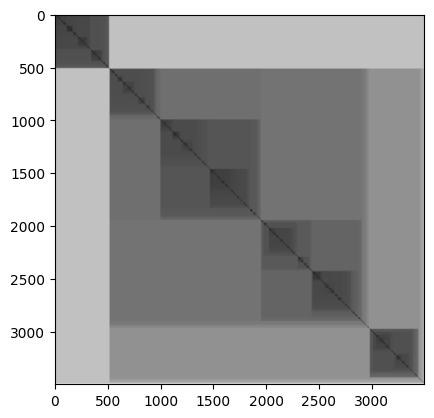

In [16]:
from VAT_library.iVAT import iVAT
from scipy.spatial.distance import cdist

pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
plt.savefig('saved_models/synthetic_hard/embed_2D.png')

iVAT Processing: 100%|██████████| 3499/3499 [00:00<00:00, 32626.53it/s]


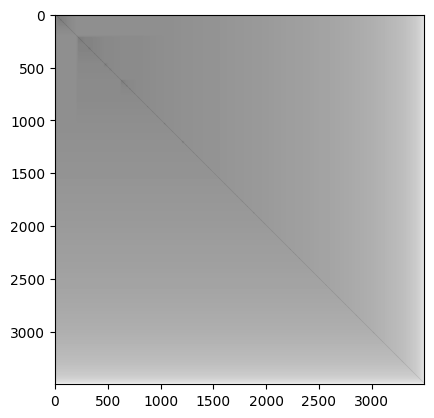

In [17]:
pairwise_dist = cdist(embedded_X_train_balanced, embedded_X_train_balanced)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
plt.savefig('saved_models/synthetic_hard/raw_embed_2D.png')

In [18]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

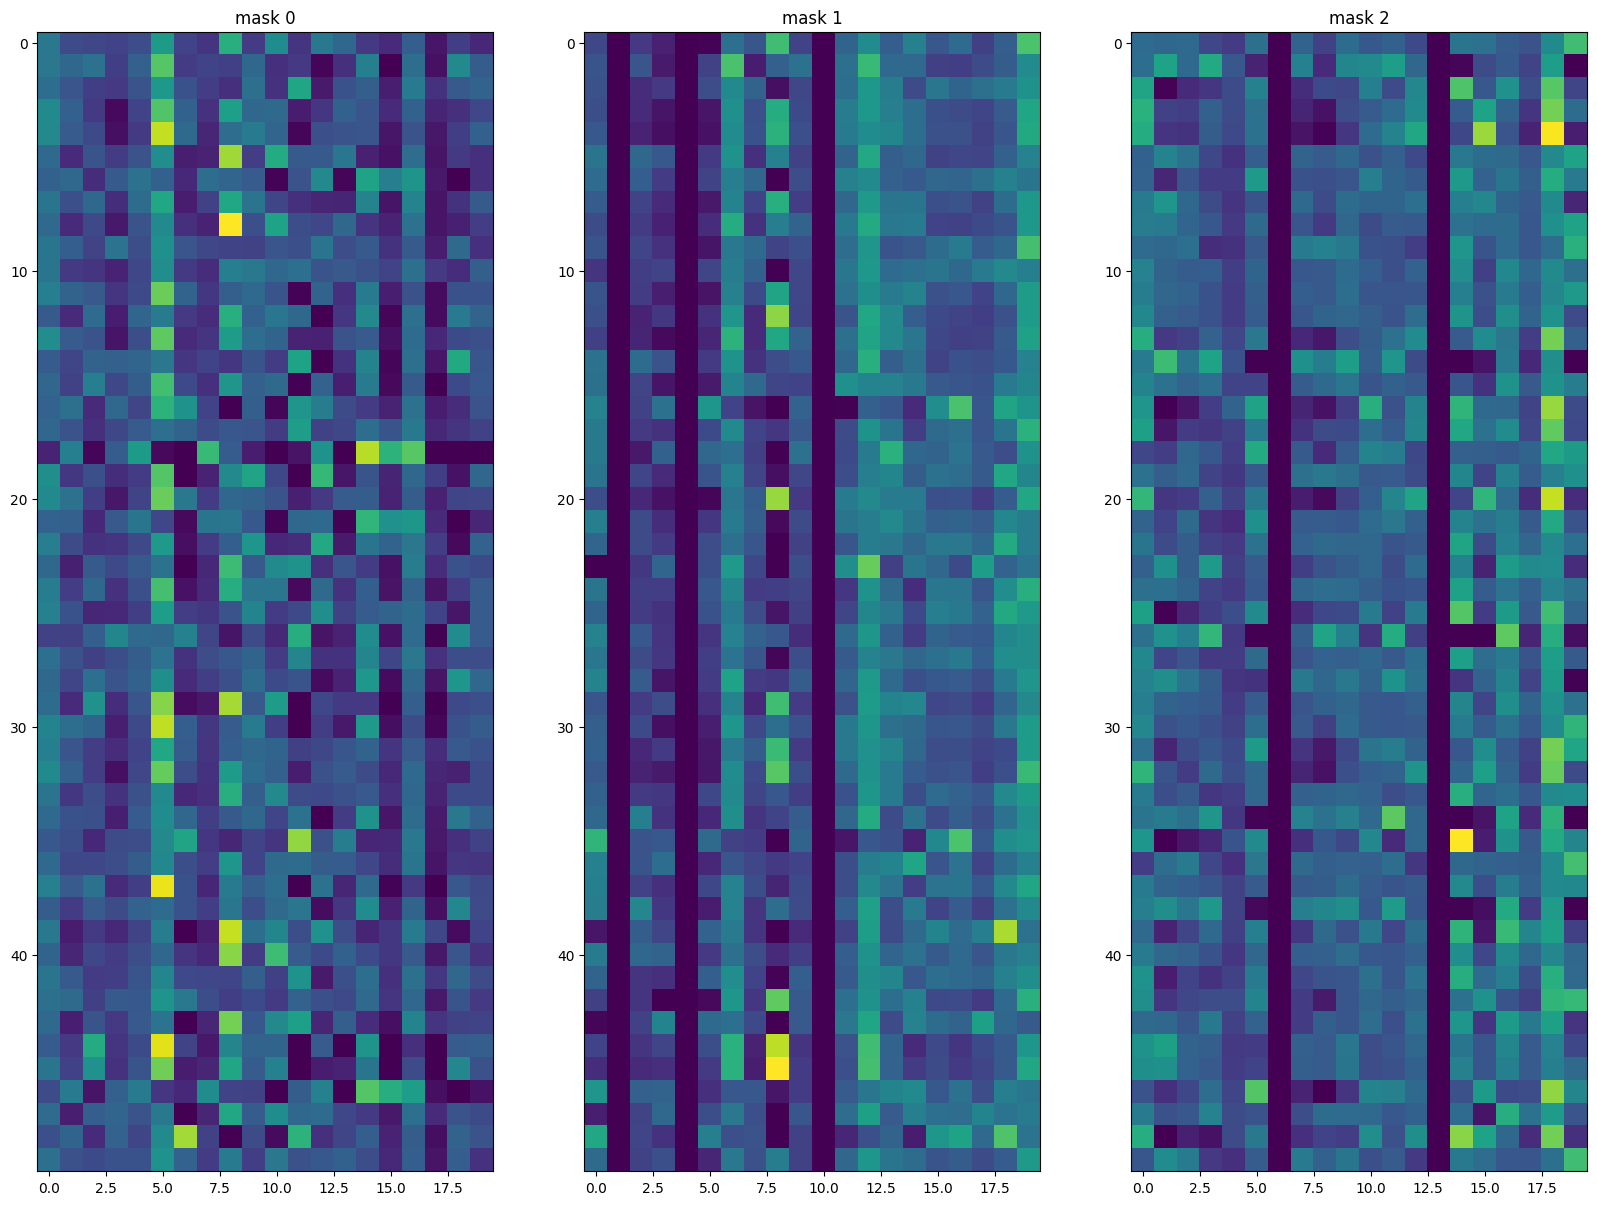

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [20]:
unsupervised_model.save_model('saved_models/synthetic_hard/synth_hard_1000_epochs')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('saved_models/synthetic_hard/synth_hard_1000_epochs.zip')

Successfully saved model at saved_models/synthetic_hard/synth_hard_1000_epochs.zip


/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [ ]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

In [ ]:
# plot losses
plt.plot(clf.history['loss'])

In [ ]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

In [ ]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

In [ ]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
